<a href="https://colab.research.google.com/github/Alexkkir/Singular-Approximation/blob/main/GlitchEffect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from google.colab import drive
drive.mount('/content/gdrive')

import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision

from scipy import linalg
from numpy.random import default_rng
from numpy.linalg import matrix_rank as rank
import math

import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
def get_images(url = "/content/gdrive/My Drive/Програмки/SingularApproximation", Resize = True, CenterCrop = True, num_channels = 3):
  filter = []
  if num_channels == 1:
    filter = [transforms.Grayscale(num_output_channels=1)]
  if Resize == True:
    filter.append(transforms.Resize(28))
  else:
    filter.append(transforms.Resize(1000))
  if CenterCrop == True:
    filter.append(transforms.CenterCrop(28))
  filter.append(transforms.ToTensor())
  data_transforms_to_work = transforms.Compose(filter)
  image_datasets_to_work = torchvision.datasets.ImageFolder(root = url, transform=data_transforms_to_work)
  num_photos = len(image_datasets_to_work)

  image_datasets = []
  for x in range(len(image_datasets_to_work)):
    elem = image_datasets_to_work[x]
    elem = elem[0]
    elem = torch.squeeze(elem)
    # elem = torchvision.transforms.functional.rotate(elem, -90)
    elem = elem.numpy()
    # elem = np.rollaxis(elem, 1, 3)
    if num_channels == 3:
      elem = np.rollaxis(elem, 0, 3)


    # min = [torch.min(elem[i]) for i in range(3)]
    # max = [torch.max(elem[i]) for i in range(3)]

    # #точка белого и точка черного
    # for d in range(3):
    #   layer = elem[d]
    #   layer = layer - min
    #   layer = layer / (max - min) * 255
    #   height, width = layer.shape
    #   for i in range(height):
    #     for j in range(width):
    #       if layer[i][j] < 0:
    #         layer[i][j] = 0
    #       if layer[i][j] > 255:
    #         layer[i][j] = 255
    #   elem[d] = layer

    # #инверсия
    # elem = 255 - elem

    image_datasets.append(elem)
  print(f"Num of images: {len(image_datasets)}")
  return image_datasets

In [9]:
def print_image(image, mode = "rgb", title = None):
  # plt.imshow(image, cmap='gray', vmin=0, vmax=255) # ч/б
  fig = plt.figure(figsize=(8, 8))
  fig.add_subplot(1, 1, 1, xticks = [], yticks = [])
  if mode == "rgb":
    plt.imshow(image, )
  elif mode == "wb":
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
  else:
    raise ValueError
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(image.shape[1])
  plt.ylabel(image.shape[0])
  if title is not None:
    plt.title(title)
  plt.show()

def print_approximations(image, range_of_ranks):
  n = len(range_of_ranks) + 1
  width = 6
  height = (n + width - 1) // width

  fig = plt.figure(figsize=(25, 10))
  fig.add_subplot(height, width, 1, xticks=[], yticks=[])
  plt.imshow(image)
  plt.title(f"original")

  svd = make_svd_from_image(image)
  for i in range(n - 1):
    index = i + 2
    # fig.add_subplot(height, width, (index % height) * width + 1 * (index // height + 1), xticks=[], yticks=[])
    fig.add_subplot(height, width, index, xticks=[], yticks=[])
    plt.imshow(make_image_from_svd(svd, range_of_ranks[i]))
    plt.title(f"rank = {range_of_ranks[i]}")

  plt.show()

def print_list_of_images(images):
  n = len(images)
  # height = 2
  # width = (n + height - 1) // height
  width = 6
  height = (n + width - 1) // width

  fig = plt.figure(figsize=(25, 5))
  for i in range(n):
    index = i + 1
    fig.add_subplot(height, width, index, xticks=[], yticks=[])
    plt.imshow(images[i])
    plt.title(f"№ {i}");
  plt.show()

In [4]:
def make_svd_from_image(image):
  if len(image.shape) == 3:
    image = np.rollaxis(image, 2)
    layers = [image[d][:][:] for d in range(3)]
    svd = []
    for layer in layers:
      svd.append(linalg.svd(layer))
    return svd
  elif len(image.shape) == 2:
    return [linalg.svd(image)]
  else:
    raise ValueError(f"Image is not grayscale of rgb")

def make_image_from_svd(svd, r):
  if len(svd) == 1:
    V, s, Uh = svd[0]
    m, n = V.shape[0], Uh.shape[1]
    sigma = np.zeros((m, n))
    
    for i in range(min(m, n, r)):
        sigma[i, i] = s[i]
    B = V @ sigma @ Uh
    return B
  elif len(svd) == 3:
    new_layers = [make_image_from_svd([svd[d]], r) for d in range(3)]
    new_im = np.rollaxis(np.array(new_layers), 0, 3)
    return new_im
  else:
    raise ValueError(f"Image is not grayscale of rgb")

def singular_approximation(A, rank):
  if len(A.shape) == 2:
    m, n = A.shape
    V, s, Uh = linalg.svd(A)
    sigma = np.zeros((m, n))

    for i in range(min(m, n, rank)):
        sigma[i, i] = s[i]
    B = V @ sigma @ Uh
    return B
  elif len(A.shape) == 3:
    aux = np.rollaxis(image, 2)
    layers = [aux[d][:][:] for d in range(3)]
    svd = []
    for layer in layers:
      svd.append(linalg.svd(layer))
    new_layers = [singular_approximation(layer, r) for layer in layers]
    new_im = np.rollaxis(np.array(new_layers), 0, 3)
    return new_im
  else:
    raise ValueError(f"Image is not grayscale of rgb")


Num of images: 11


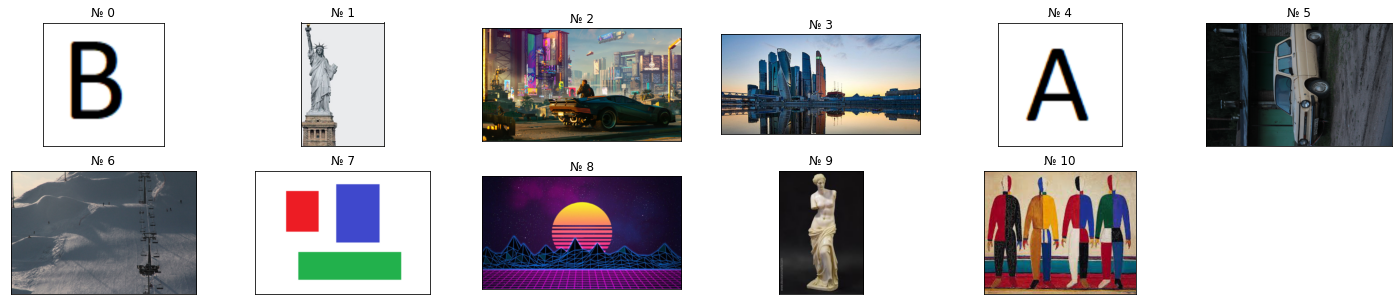

In [7]:
images = get_images(Resize=False, CenterCrop=False, num_channels = 3)

print_list_of_images(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

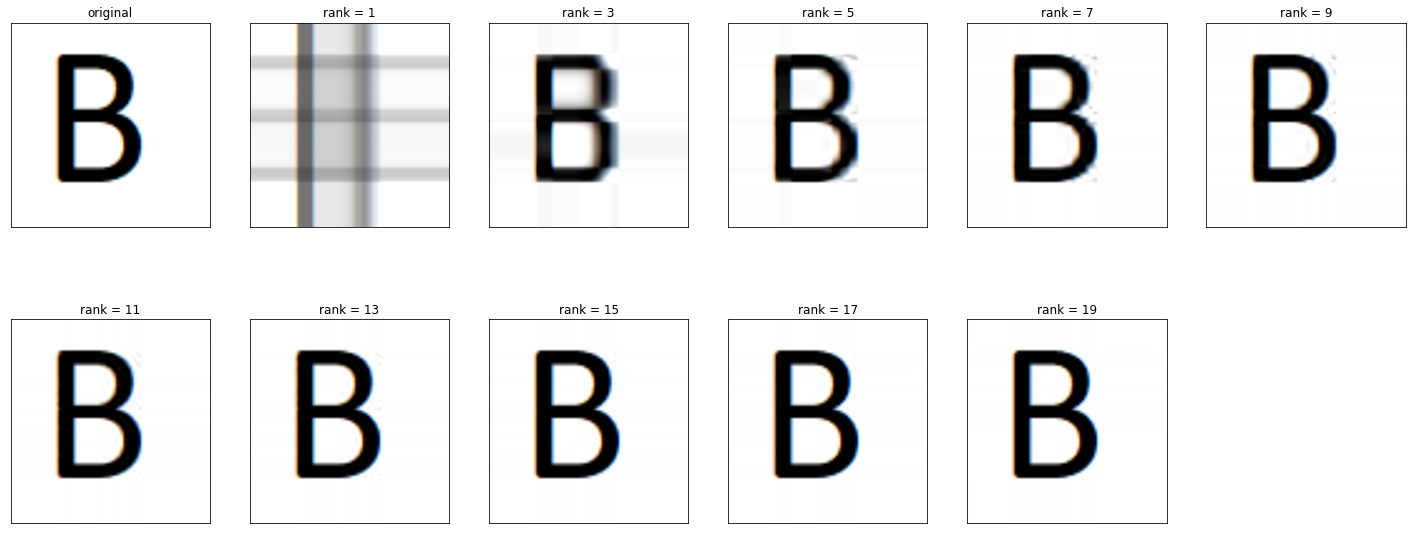

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

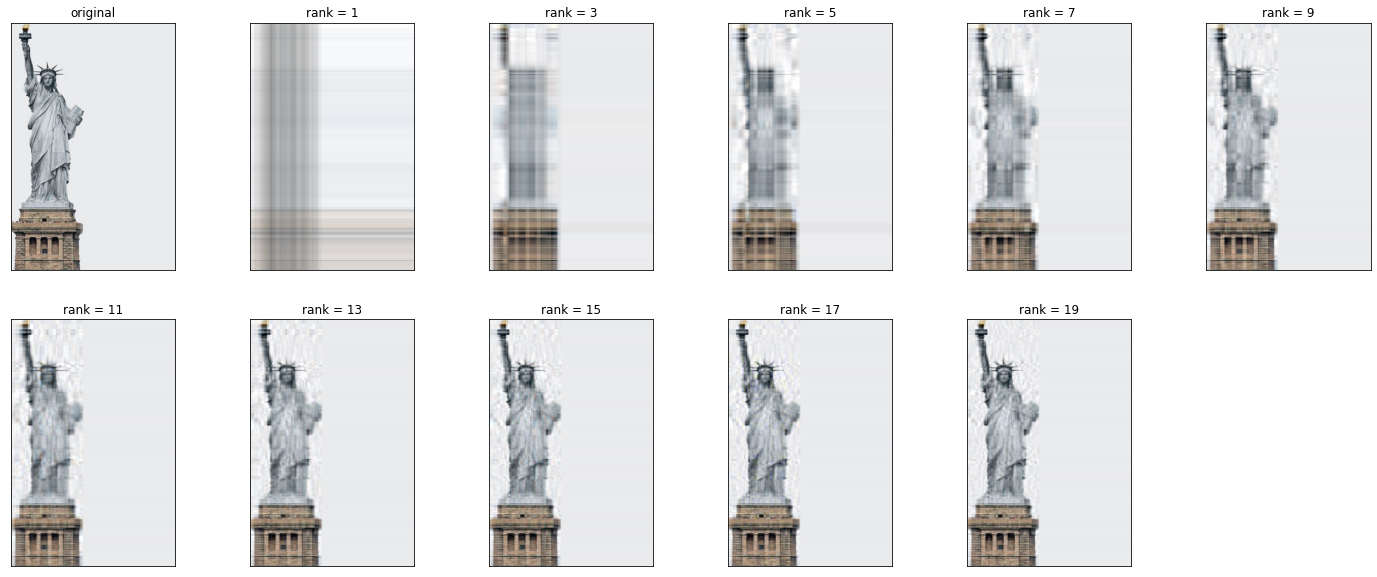

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

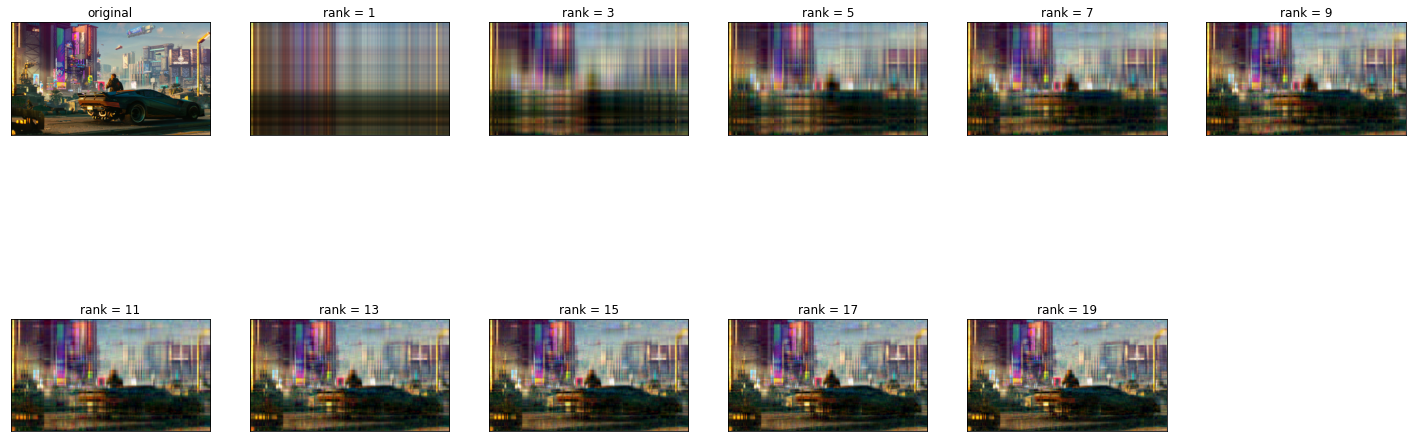

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

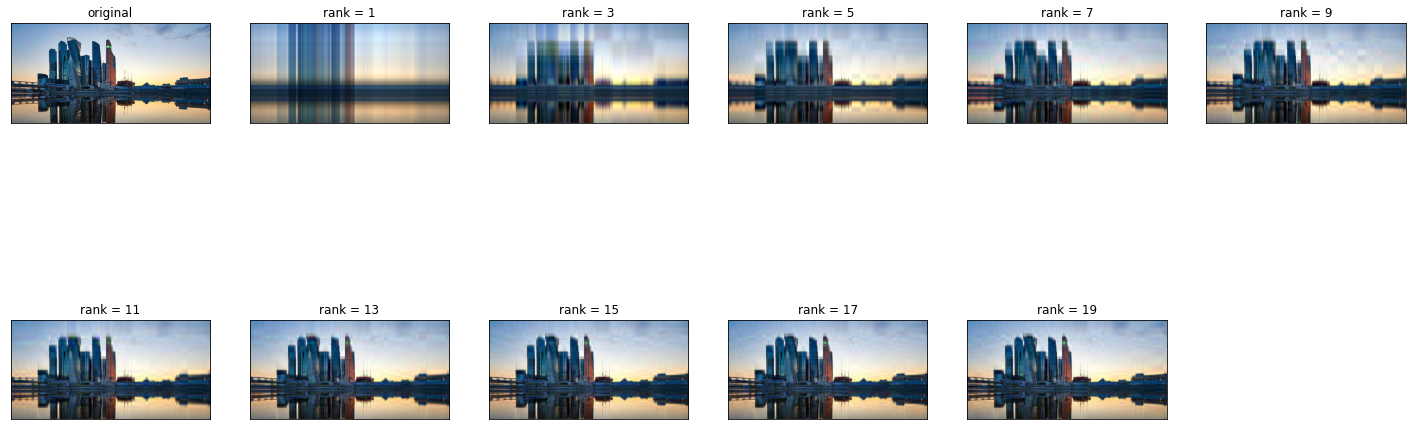

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

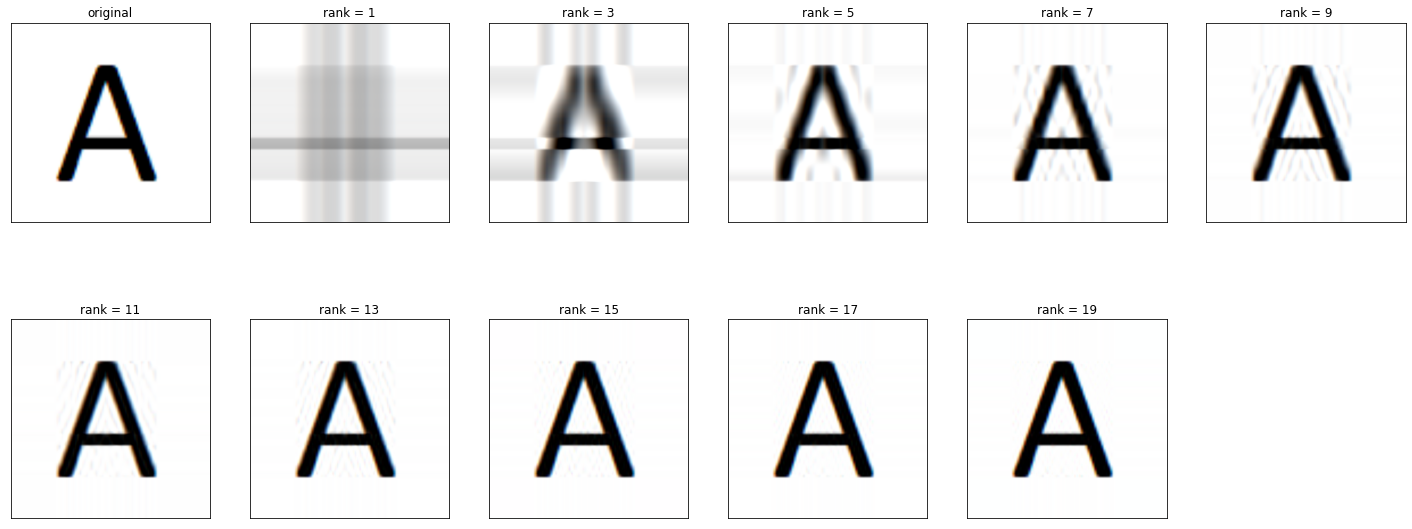

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


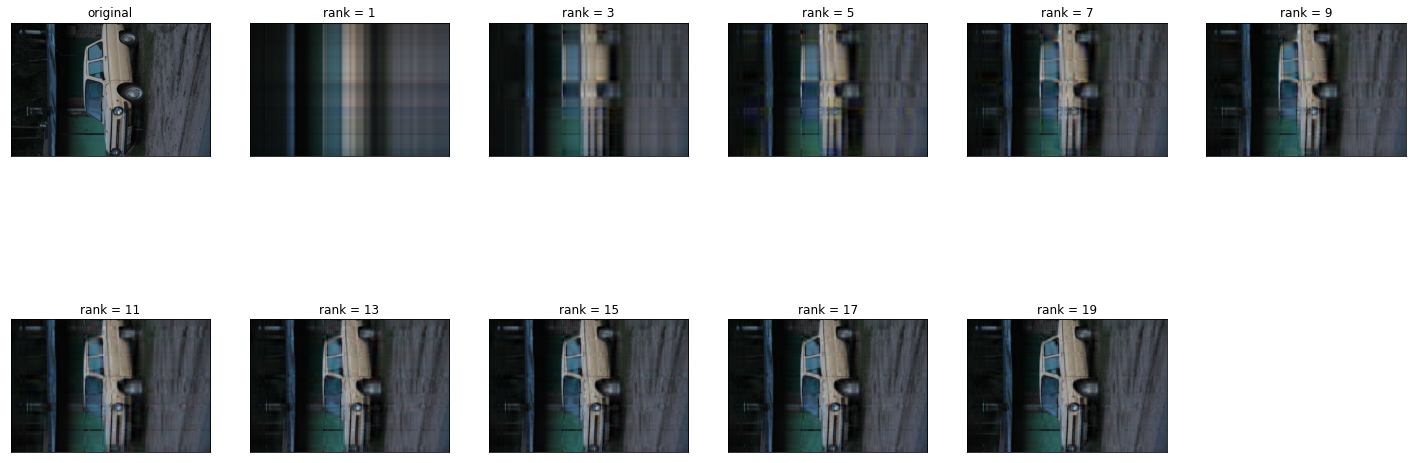

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


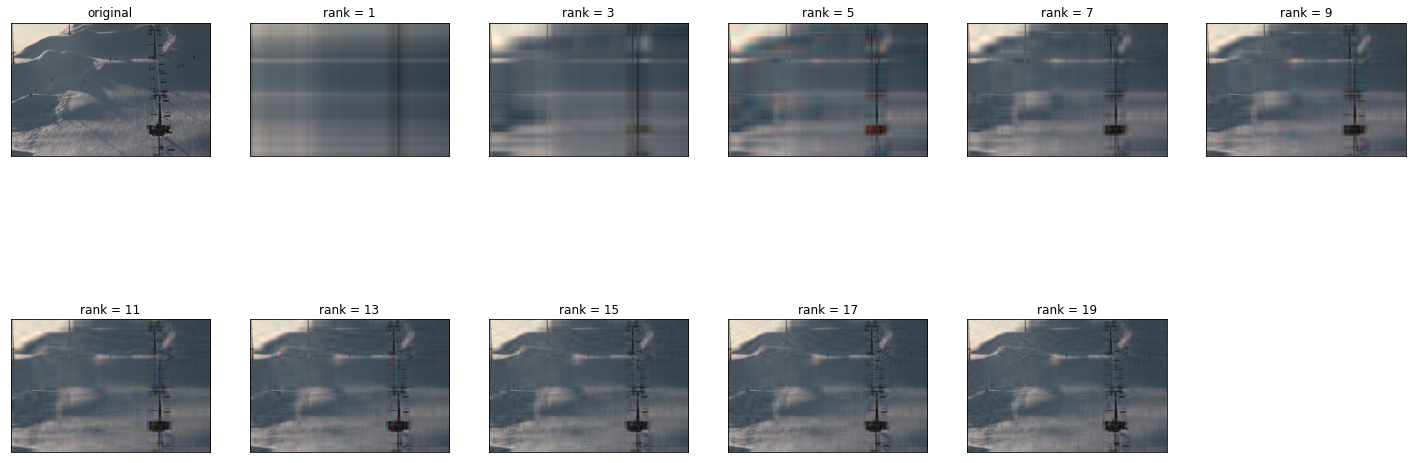

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

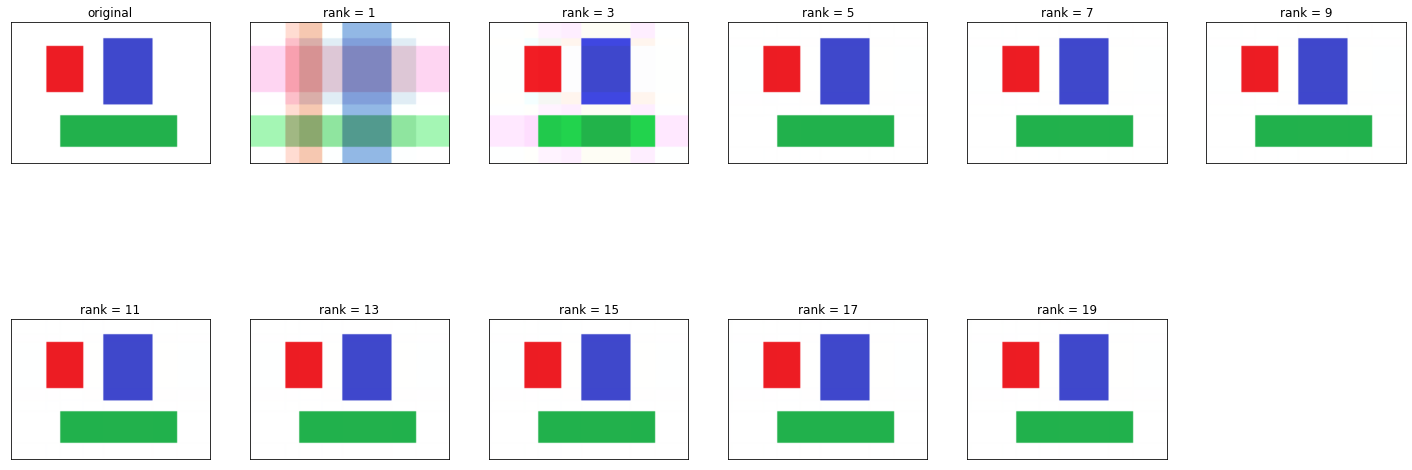

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

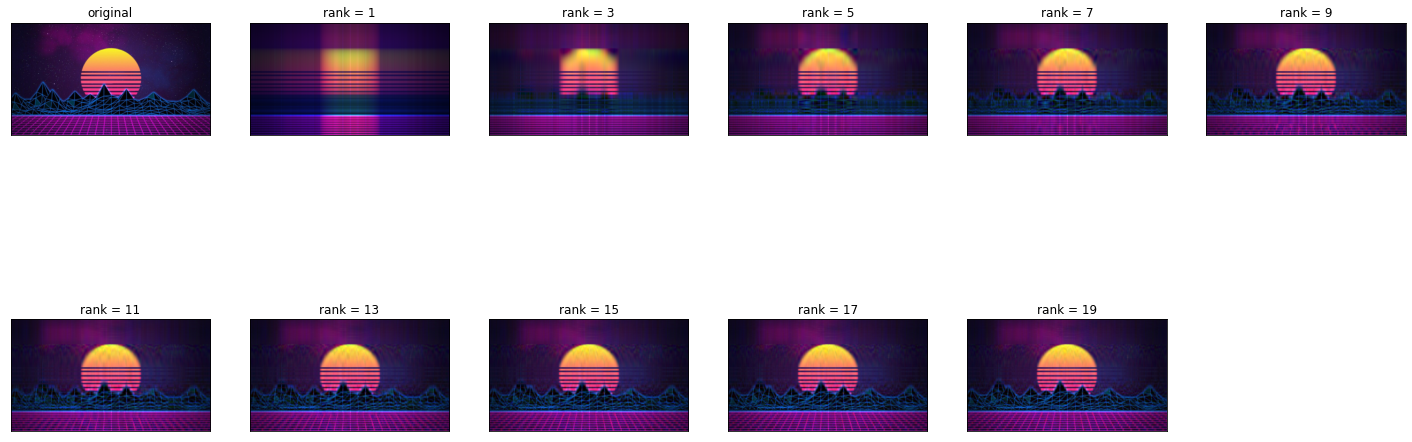

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


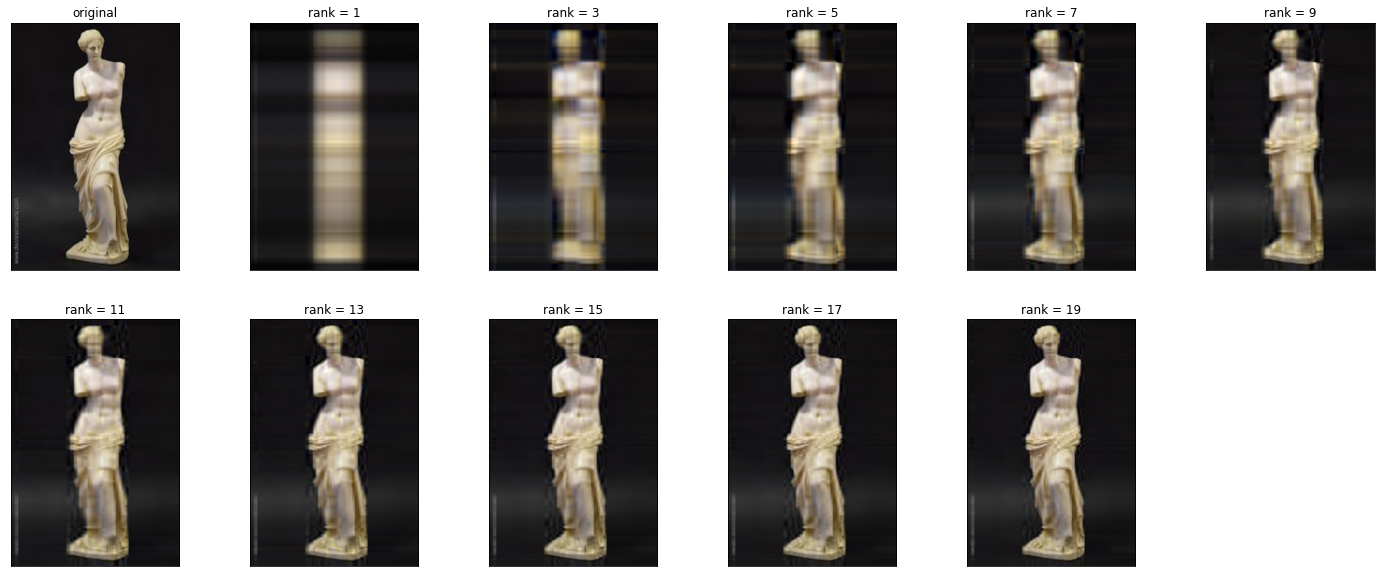

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

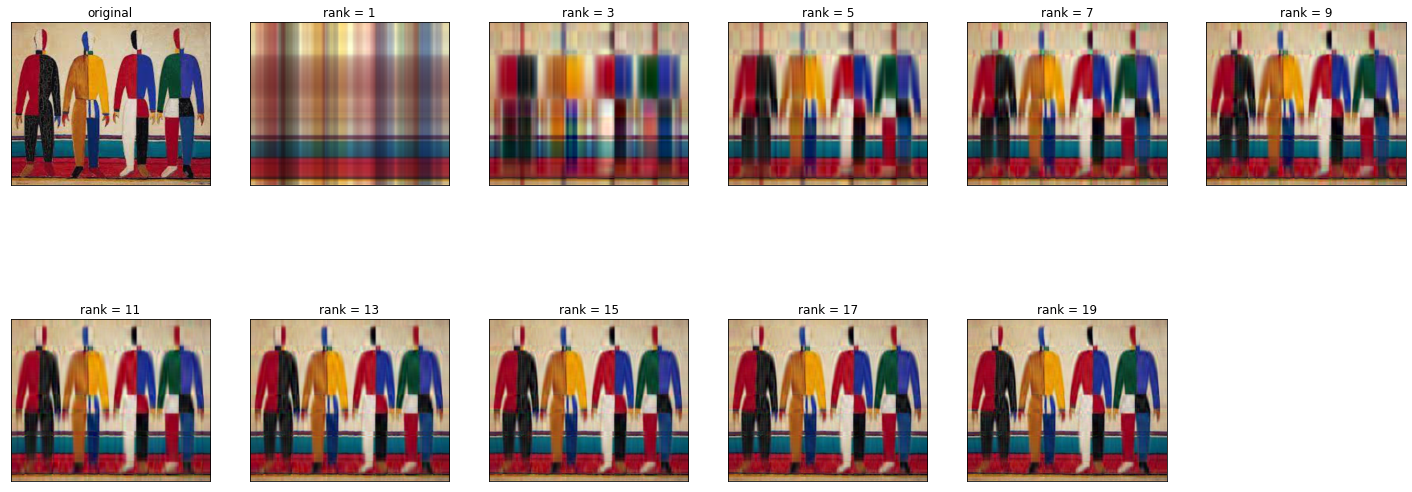

In [10]:
for image in images:
  print_approximations(image, range(1, 20, 2))
  print()
  print()